In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Load Loss Data

In [52]:
save_dir = "saves"
learning_rates = [1e-3, 5e-4, 8e-4] # [1e-4, 2e-4, 5e-4, 8e-4, 1e-3, 2e-3, 5e-3, 8e-3]

def load_npy(model_prefix, metric, lr):
    filename = f"{model_prefix}_{metric}_lr_{lr:.0e}.npy"
    path = os.path.join(save_dir, filename)
    return np.load(path, allow_pickle=True)

### Compute metrics

In [53]:
def get_loss_std(losses_list):
    return [np.std(batch_losses) for batch_losses in losses_list]

def get_grad_predictiveness(grads_array): 
    result = []
    prev = None
    for epoch_grads in grads_array:  # epoch_grads: (num_batch, 10, 512)
        flat = epoch_grads.reshape(-1)  # shape: (391 * 10 * 512,)
        if prev is None:
            result.append(0.0)
        else:
            delta = np.linalg.norm(flat - prev)
            denom = np.linalg.norm(prev) + 1e-8
            result.append(delta / denom)
        prev = flat
    return result

### Plot

In [55]:
def robust_max_curve(matrix, threshold=1.5):
    robust_max = []
    for col in matrix.T:
        sorted_vals = np.sort(col)[::-1]
        if sorted_vals[0] > threshold and len(sorted_vals) > 1:
            robust_max.append(sorted_vals[1])
        else:
            robust_max.append(sorted_vals[0])
    return np.array(robust_max)

In [67]:
def plot_metric_with_range(metric_lists_vgg, metric_lists_bn, ylabel, title, save_name, epochs, threshold=0.2, forbid=True):
    """
    metric_lists_vgg/bn: list of shape=(num_lrs, num_epochs) numpy arrays
    """
    metric_lists_vgg = np.array(metric_lists_vgg)[:, :epochs]
    metric_lists_bn = np.array(metric_lists_bn)[:, :epochs]

    steps = np.arange(epochs)
    
    # 屏蔽异常值
    if forbid:
        metric_lists_vgg = np.where(metric_lists_vgg > 0.3, np.nan, metric_lists_vgg)
        metric_lists_bn = np.where(metric_lists_bn > 0.3, np.nan, metric_lists_bn)

    min_vgg = np.min(metric_lists_vgg, axis=0)
    max_vgg = np.max(metric_lists_vgg, axis=0)
    # max_vgg = robust_max_curve(metric_lists_vgg, threshold=threshold)
    min_bn = np.min(metric_lists_bn, axis=0)
    max_bn = np.max(metric_lists_bn, axis=0)
    # max_bn = robust_max_curve(metric_lists_bn, threshold=threshold)

    plt.figure(figsize=(10, 6))
    # VGG fill
    plt.fill_between(steps, min_vgg, max_vgg, color='red', alpha=0.3)
    plt.plot(steps, min_vgg, '--', color='red')
    plt.plot(steps, max_vgg, '-', color='red', label='VGG')
    # BN fill
    plt.fill_between(steps, min_bn, max_bn, color='blue', alpha=0.3)
    plt.plot(steps, min_bn, '--', color='blue')
    plt.plot(steps, max_bn, '-', color='blue', label='VGG+BatchNorm')

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(save_dir, save_name))
    plt.show()


### main

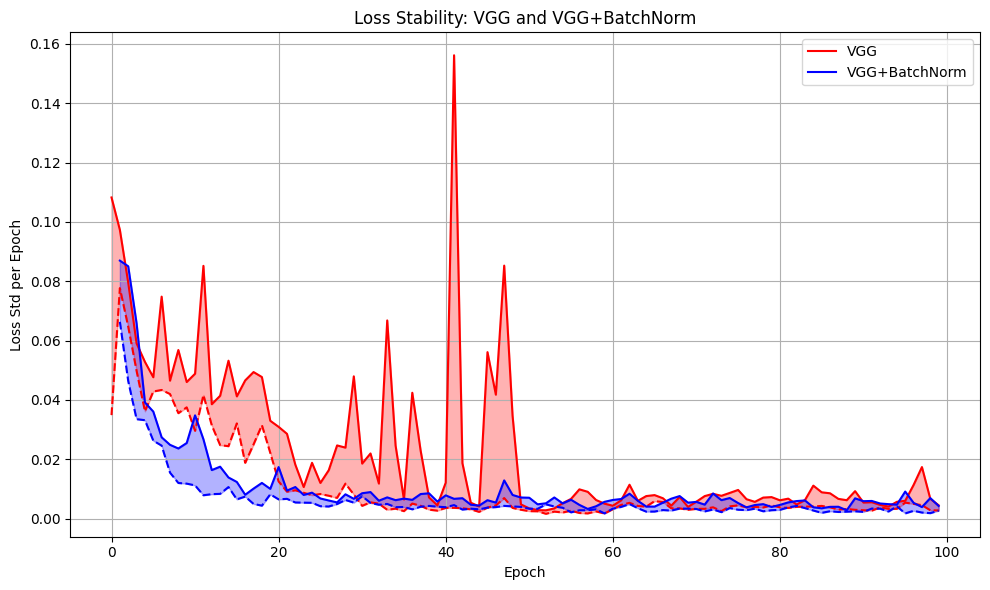

In [60]:
loss_std_vgg_all = []
loss_std_bn_all = []

epochs = 100

for lr in learning_rates:
    # Loss std
    loss_vgg = load_npy("vgg", "loss", lr)[:epochs]
    loss_bn = load_npy("bn", "loss", lr)[:epochs]
    loss_std_vgg_all.append(get_loss_std(loss_vgg))
    loss_std_bn_all.append(get_loss_std(loss_bn))
    
plot_metric_with_range(
    metric_lists_vgg=loss_std_vgg_all,
    metric_lists_bn=loss_std_bn_all,
    ylabel="Loss Std per Epoch",
    title="Loss Stability: VGG and VGG+BatchNorm",
    save_name="loss_std_fill_between.png",
    epochs=epochs
)

In [ ]:
grad_pred_vgg_all = []
grad_pred_bn_all = []

epochs = 250

for lr in learning_rates:
    # Grad predictiveness
    grads_vgg = load_npy("vgg", "grads", lr)[:epochs]
    grads_bn = load_npy("bn", "grads", lr)[:epochs]
    
    # print(grads_vgg.shape)
    grad_pred_vgg_all.append(get_grad_predictiveness(grads_vgg))
    grad_pred_bn_all.append(get_grad_predictiveness(grads_bn))

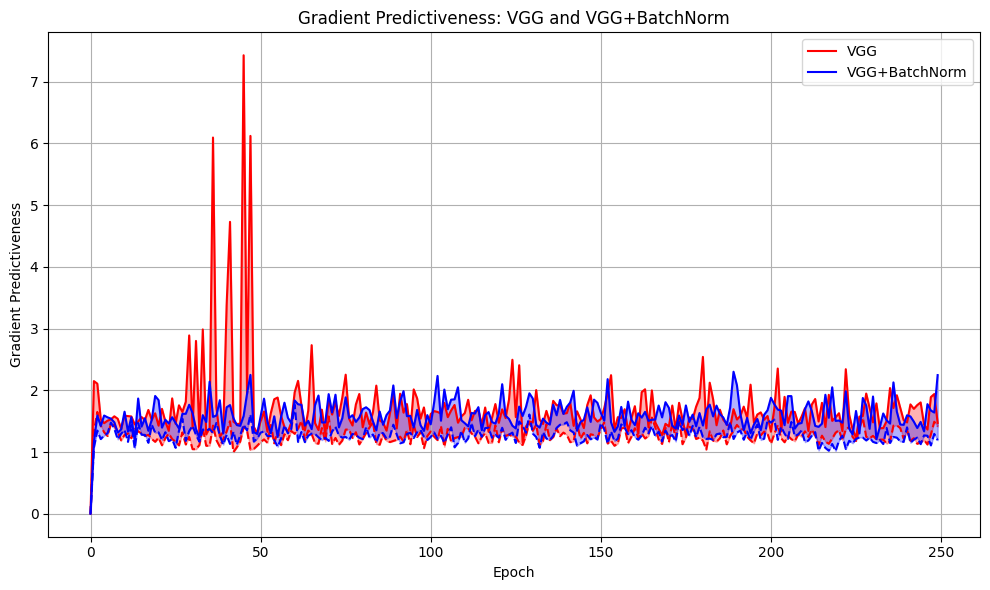

In [68]:
plot_metric_with_range(
    metric_lists_vgg=grad_pred_vgg_all,
    metric_lists_bn=grad_pred_bn_all,
    ylabel="Gradient Predictiveness",
    title="Gradient Predictiveness: VGG and VGG+BatchNorm",
    save_name="grad_pred_fill_between.png",
    epochs=epochs,
    forbid=False
)

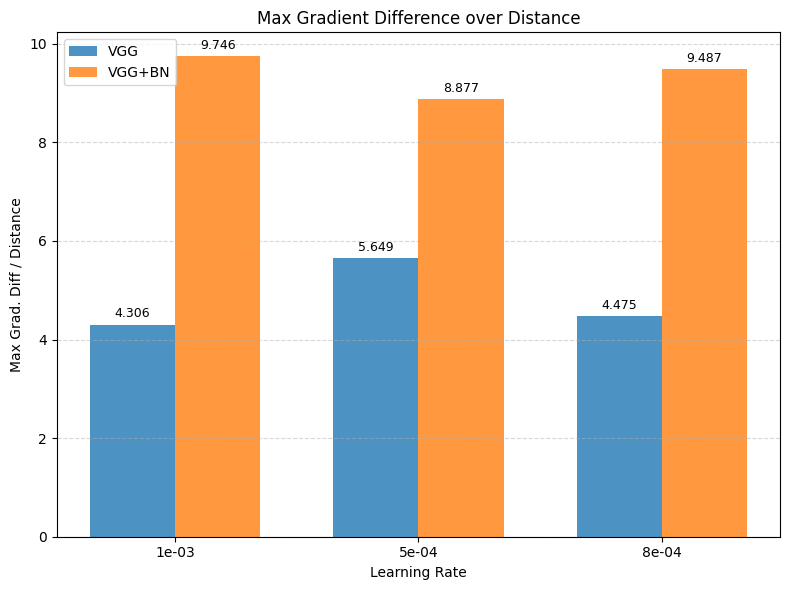

In [71]:
vgg_vals = []
bn_vals = []

for lr in learning_rates:
    vgg_val = np.load(f"saves/vgg_maxgraddist_lr_{lr:.0e}.npy")[0]
    bn_val = np.load(f"saves/bn_maxgraddist_lr_{lr:.0e}.npy")[0]
    vgg_vals.append(vgg_val)
    bn_vals.append(bn_val)

x = np.arange(len(learning_rates))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, vgg_vals, width, label='VGG', alpha=0.8)
rects2 = ax.bar(x + width/2, bn_vals, width, label='VGG+BN', alpha=0.8)

ax.set_ylabel("Max Grad. Diff / Distance")
ax.set_xlabel("Learning Rate")
ax.set_title("Max Gradient Difference over Distance")
ax.set_xticks(x)
ax.set_xticklabels([f"{lr:.0e}" for lr in learning_rates])
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

def annotate_bars(rects):
    for r in rects:
        height = r.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(r.get_x() + r.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()

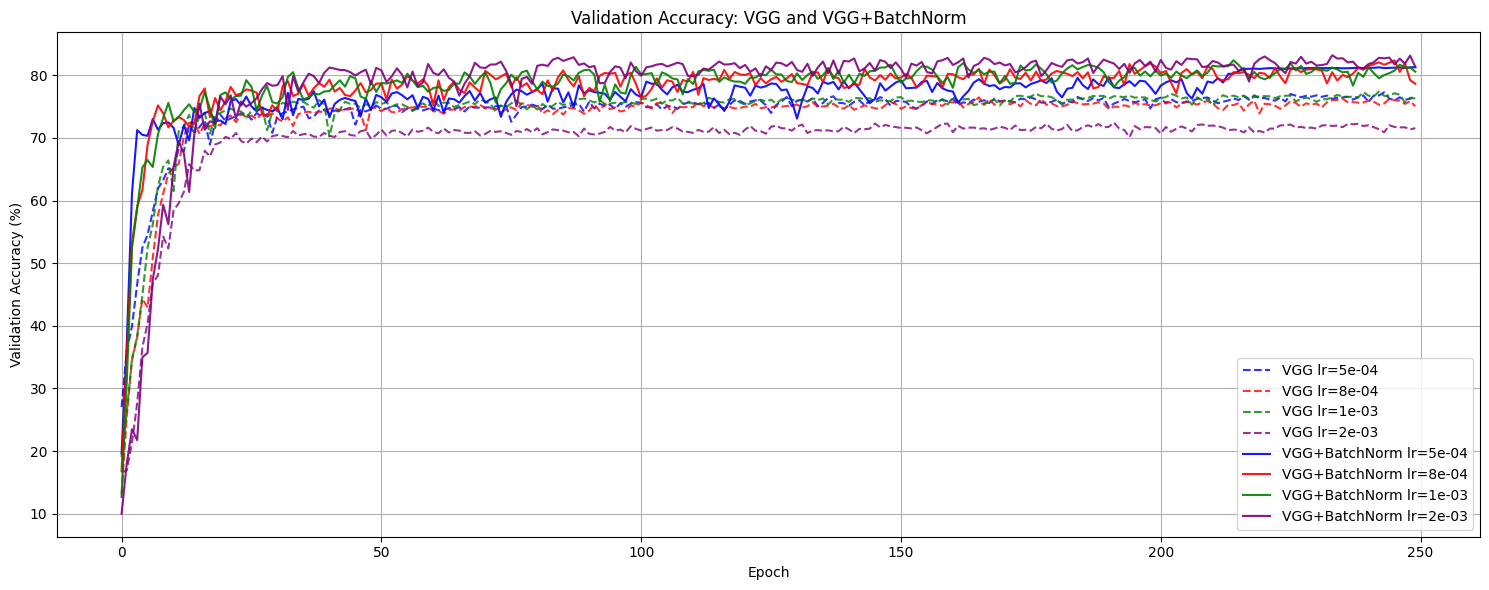

In [80]:
save_dir = "saves"
learning_rates = [5e-4, 8e-4, 1e-3, 2e-3]
epochs = 250

vgg_acc_all = []
bn_acc_all = []

for lr in learning_rates:
    vgg_path = os.path.join(save_dir, f"vgg_acc_lr_{lr:.0e}.npy")
    bn_path = os.path.join(save_dir, f"bn_acc_lr_{lr:.0e}.npy")
    if os.path.exists(vgg_path) and os.path.exists(bn_path):
        vgg_acc = np.load(vgg_path, allow_pickle=True)[:epochs]
        bn_acc = np.load(bn_path, allow_pickle=True)[:epochs]
        vgg_acc_all.append((lr, vgg_acc))
        bn_acc_all.append((lr, bn_acc))

plt.figure(figsize=(15, 6))

color = ["blue", "red", "green", "purple"]

for i, (lr, acc) in enumerate(vgg_acc_all):
    plt.plot(acc, '--', label=f"VGG lr={lr:.0e}", alpha=0.8, color=color[i])
for i, (lr, acc) in enumerate(bn_acc_all):
    plt.plot(acc, '-', label=f"VGG+BatchNorm lr={lr:.0e}", alpha=0.9, color=color[i])

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy: VGG and VGG+BatchNorm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
vgg_acc_all = [np.array(curve, dtype=np.float32) for curve in vgg_acc_all]
bn_acc_all  = [np.array(curve, dtype=np.float32) for curve in bn_acc_all]

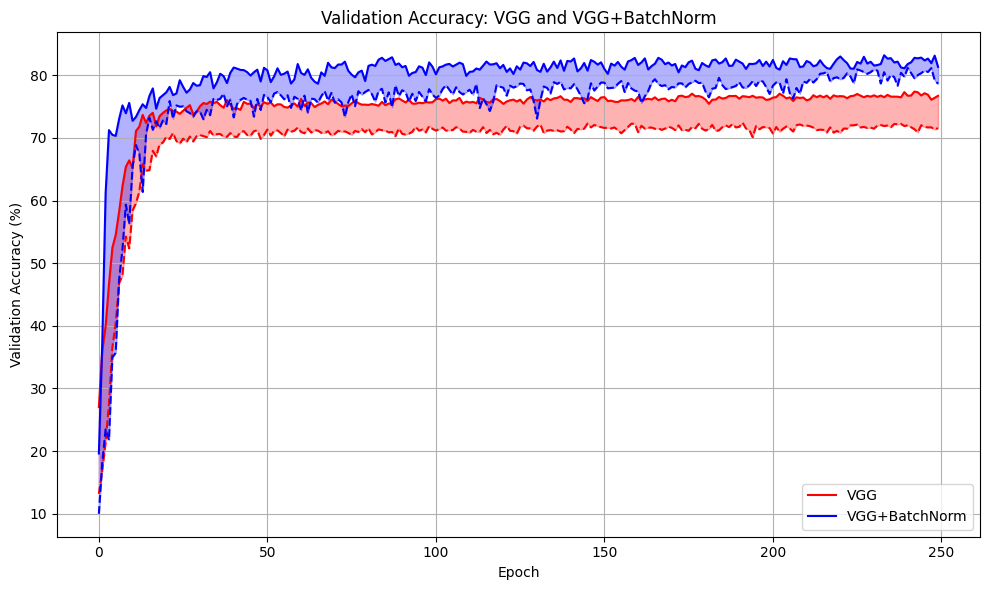

In [92]:
plot_metric_with_range(
    metric_lists_vgg=vgg_acc_all,
    metric_lists_bn=bn_acc_all,
    ylabel="Validation Accuracy (%)",
    title="Validation Accuracy: VGG and VGG+BatchNorm",
    epochs=epochs,
    save_name="",
    forbid=False
)